In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [3]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A2, A1=A1, G1=G1, G2=G2,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0,
            stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PASSED


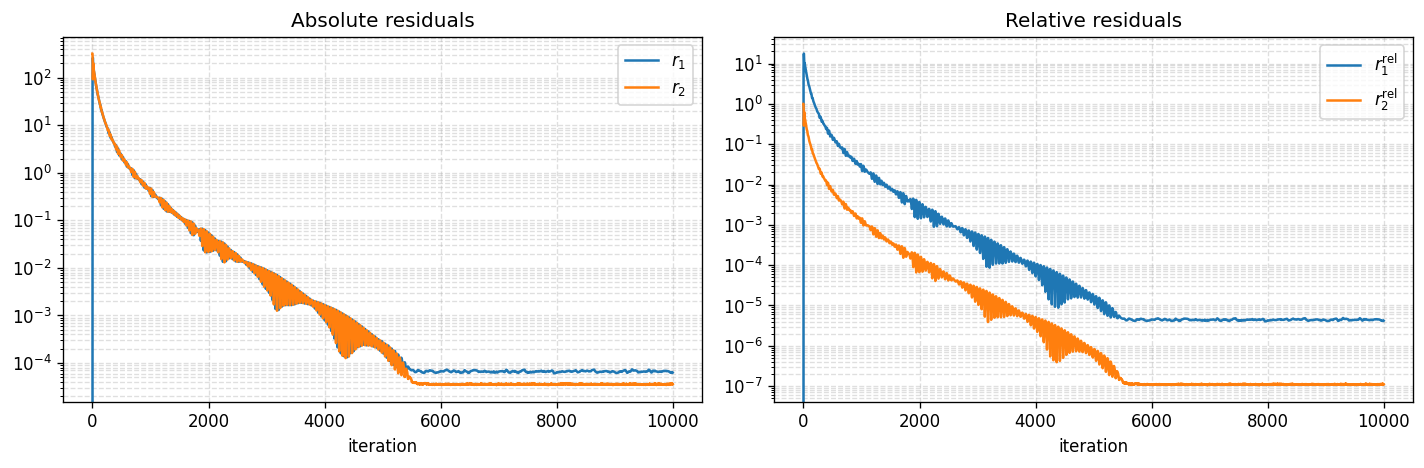

In [4]:
plot_residuals(residuals)

## Dual feasibility checks

In [5]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
        _, res2 = Y_dual_feasible(A1=B.to(torch.float32), A2=A.to(torch.float32), G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr", maxit=1000)
        print("residual:", res1, "residual (float32):", res2)

30x60
residual: {'res_C': 7.395190682077207e-08, 'res': 7.857218390154141e-07, 'iter': 44} residual (float32): {'res_C': 8.67251343284418e-08, 'res': 9.214343891584895e-07, 'iter': 44}
residual: {'res_C': 7.89451851648278e-08, 'res': 8.905994408309088e-07, 'iter': 48} residual (float32): {'res_C': 8.990352251990397e-08, 'res': 1.0142230059301848e-06, 'iter': 48}
residual: {'res_C': 9.08076283236199e-08, 'res': 9.86124145635685e-07, 'iter': 44} residual (float32): {'res_C': 7.91862725193172e-08, 'res': 8.599221522105521e-07, 'iter': 45}
residual: {'res_C': 6.563356741695694e-08, 'res': 7.320625900495421e-07, 'iter': 41} residual (float32): {'res_C': 8.143012289434794e-08, 'res': 9.082539444495026e-07, 'iter': 41}
residual: {'res_C': 6.931675809960154e-08, 'res': 7.456037308828981e-07, 'iter': 43} residual (float32): {'res_C': 8.404861929436909e-08, 'res': 9.040665812792113e-07, 'iter': 43}
60x30
residual: {'res_C': 6.133534039362924e-08, 'res': 7.455486354956862e-07, 'iter': 31} residua

In [6]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
    print(f"{dual_res=}")

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
        max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0, Y0=Y0,
        stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
        diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()

dual_res={'res_C': 8.731794471676747e-08, 'res': 3.384011000598568e-06, 'iter': 1000}


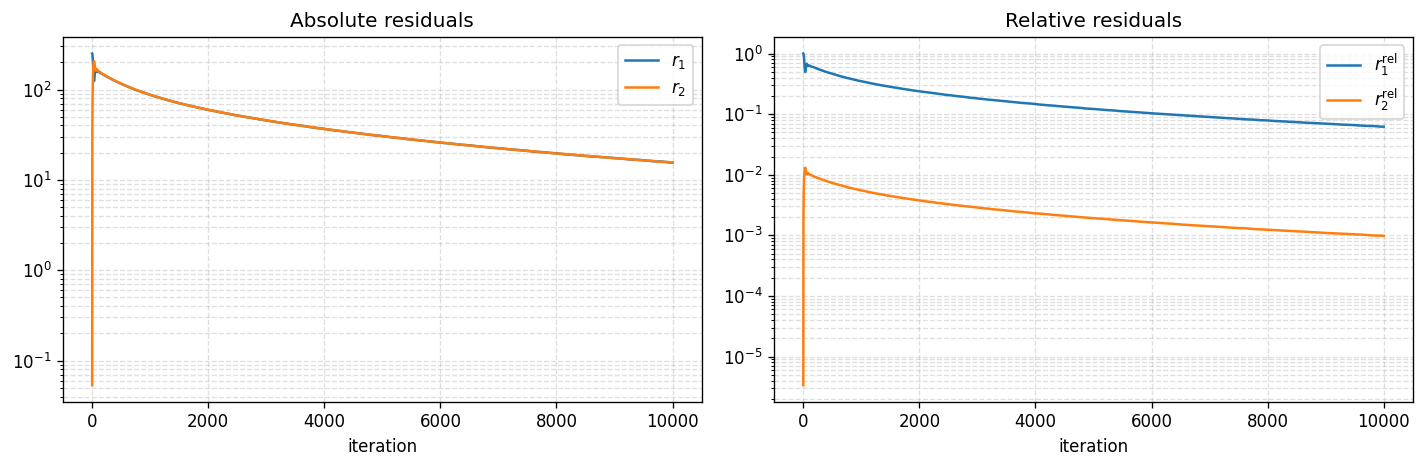

In [7]:
plot_residuals(residuals)

In [8]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(1.0, 0.013075328383508342, 0.4961312561035156, 3.38401123537447e-06)

## reHPDHG


In [10]:
for (m, n) in [(30, 60), (60, 30), (30, 30)]:
    for _ in range(1):
        # NumPy data for CVXPY reference
        A1_np = np.random.randn(m, n).astype(np.float64)
        A2_np = np.random.randn(m, n).astype(np.float64)
        Y0_np = np.random.randn(n, n).astype(np.float64)
        G1_np = A1_np @ Y0_np.T
        G2_np = A2_np @ Y0_np
        # Torch tensors
        A2 = torch.from_numpy(A2_np).to(torch.float64).to(device)
        A1 = torch.from_numpy(A1_np).to(torch.float64).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float64).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float64).to(device)

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta)
        Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)
        Z_star_1_torch = torch.tensor(Z0_1, dtype=A1.dtype, device=device)
        Z_star_2_torch = torch.tensor(Z0_2, dtype=A1.dtype, device=device)
        AZ = Z_star_1_torch.T @ A1 + A2.T @ Z_star_2_torch 
        print(pd_residuals_infty_ball(A=A2, B=A1, Y=Y_star_torch, Z1=Z_star_1_torch, Z2=Z_star_2_torch, 
                                      G1=G1, G2=G2, beta=beta, mu=0))

        
        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A2, A1=A1, G1=G1, G2=G2,
            max_iter=7000, eps_abs=1e-8, eps_rel=1e-8,
            h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=True, enable_restart=True)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        print(pd_residuals_max_ball(A1, A2, Y_t, Z_t, G1, G2, beta, mu=0))

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ A1_np + A2_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ A1_np + A2_np.T @ Z0_2)
        ) <= beta + 1e-3
print("PASSED")

(8.644385090443642, 0.28814616968145473, 1.7213319193861249e-13, 3.7282256914955844e-16)
(0.08566644595862637, 0.0028555481986208787, 0.008380712765709198, 1.8151751149368657e-05)
(1.3627880444312982e-07, 9.085253629541988e-09, 9.359502381445994e-14, 2.687878637917711e-16)
(1.4908439222333775e-14, 9.93895948155585e-16, 1.8232598375458642e-13, 5.236070219318339e-16)
(8.733832620826289e-07, 5.8225550805508597e-08, 6.80743035831342e-14, 2.9947858645910764e-16)
(5.171333558236218e-09, 3.447555705490812e-10, 8.674107735013112e-08, 3.815991330860028e-10)
PASSED


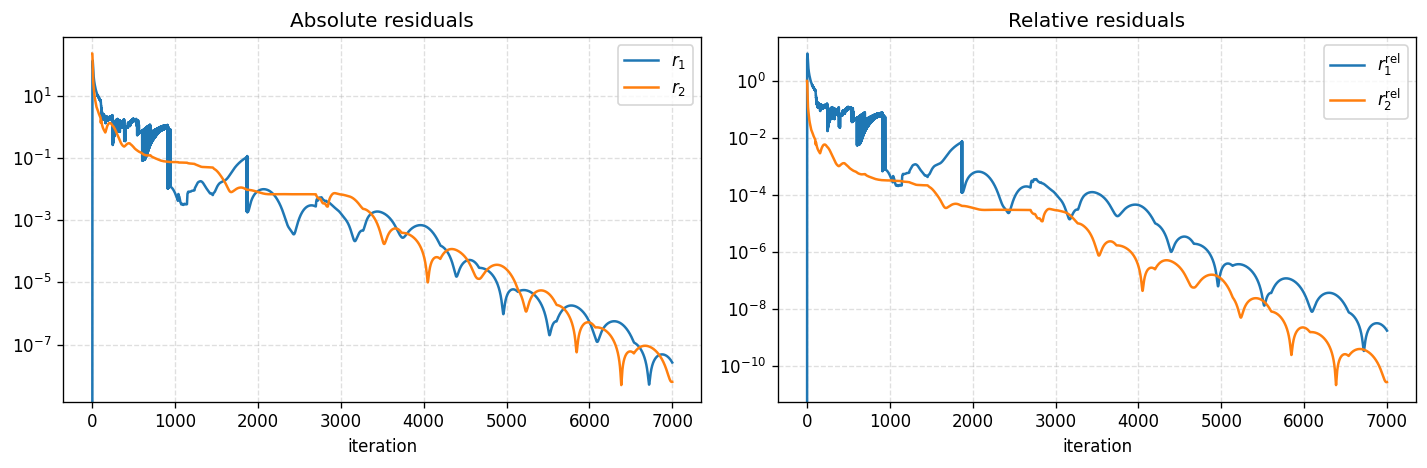

In [11]:
plot_residuals(residuals)

## Dual feasibility checks $\|\mathcal{A}^*(Y) + G\|_F$

In [12]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A2=A, A1=B, G1=G1, G2=G2, method="lsqr")
        _, res2 = Y_dual_feasible(A2=A.to(torch.float32), A1=B.to(torch.float32), 
                                  G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr")
        print("residual:", res1["res"], "residual (float32):", res2["res"])

30x60
residual: 8.093072687906225e-07 residual (float32): 9.271209887533394e-07
residual: 7.34003364476023e-07 residual (float32): 7.810647604003225e-07
residual: 9.030688005962617e-07 residual (float32): 7.828005807950572e-07
residual: 7.407405594539146e-07 residual (float32): 8.835525598902653e-07
residual: 9.736482462534602e-07 residual (float32): 1.0098672925580433e-06
60x30
residual: 7.904211488711924e-07 residual (float32): 8.108938056698994e-07
residual: 7.645189712486158e-07 residual (float32): 7.887132705733818e-07
residual: 6.489779787302305e-07 residual (float32): 7.636174125474644e-07
residual: 7.817594876602802e-07 residual (float32): 8.211475090997026e-07
residual: 6.83892614433669e-07 residual (float32): 7.144769529973877e-07
60x60
residual: 9.680151990576828e-07 residual (float32): 1.1098845935793469e-06
residual: 9.674468469041657e-07 residual (float32): 1.082005418687449e-06
residual: 9.516552575134939e-07 residual (float32): 1.1343413876021388e-06
residual: 9.4253521

In [13]:
all_res = {}

settings = {"vanilla": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "diag_scaling": {"diag_scaling": True, "equilibration": False, "reflected_halpern":False, "enable_restart": False},
            "equilibration": {"diag_scaling": False, "equilibration": True, "reflected_halpern":False, "enable_restart": False},
            "repdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": False},
            "ada_rehpdhg": {"diag_scaling": False, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
            "ada_rehpdhg_ds": {"diag_scaling": True, "equilibration": False, "reflected_halpern":True, "enable_restart": True},
           }
m = n = 500
# NumPy data for CVXPY reference
A_np = np.random.randn(m, n)
B_np = np.random.randn(m, n)
Y0_np = np.random.randn(n, n)
G1_np = B_np @ Y0_np.T
G2_np = A_np @ Y0_np

beta = 0.5 
# Torch tensors
A = torch.from_numpy(A_np).to(torch.float32).to(device)
B = torch.from_numpy(B_np).to(torch.float32).to(device)
G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

for setting in settings:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
        max_iter=10**4, eps_abs=1e-8, eps_rel=1e-8,
        stopping=False, 
        h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
        diag_scaling=settings[setting]["diag_scaling"], 
        equilibration=settings[setting]["equilibration"],
        reflected_halpern=settings[setting]["reflected_halpern"],
        enable_restart=settings[setting]["enable_restart"],
        verbose=True
    )
    all_res[setting] = residuals

    # Back to NumPy for comparison
    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()


||A||_op <= 7.0566e+02
||A||_op <= 7.0566e+02
||A||_op <= 7.0566e+02
||A||_op <= 2.5348e+02
||A||_op <= 7.0566e+02
||A||_op <= 7.0566e+02
[RESTART] iter= 100 primal_weight=3.8062e+00 r_prim=8.302e+00 r_dual=6.654e-02
[RESTART] iter= 157 primal_weight=5.0247e-01 r_prim=4.195e+00 r_dual=3.399e-02
[RESTART] iter= 246 primal_weight=1.6095e+00 r_prim=1.839e+00 r_dual=5.013e-02
[RESTART] iter= 385 primal_weight=6.9869e-01 r_prim=1.961e+00 r_dual=1.901e-02
[RESTART] iter= 602 primal_weight=9.8245e-01 r_prim=4.863e-01 r_dual=1.138e-02
[RESTART] iter= 941 primal_weight=1.0938e+00 r_prim=2.444e-01 r_dual=3.265e-03
[RESTART] iter=1471 primal_weight=9.5561e-01 r_prim=1.070e-01 r_dual=1.226e-03
[RESTART] iter=2299 primal_weight=9.9649e-01 r_prim=6.533e-02 r_dual=4.422e-04
[RESTART] iter=3593 primal_weight=1.0655e+00 r_prim=4.214e-02 r_dual=1.453e-04
[RESTART] iter=5615 primal_weight=8.3586e-01 r_prim=3.326e-02 r_dual=5.441e-05
[RESTART] iter=8774 primal_weight=8.8259e-01 r_prim=1.735e-02 r_dual=2.2

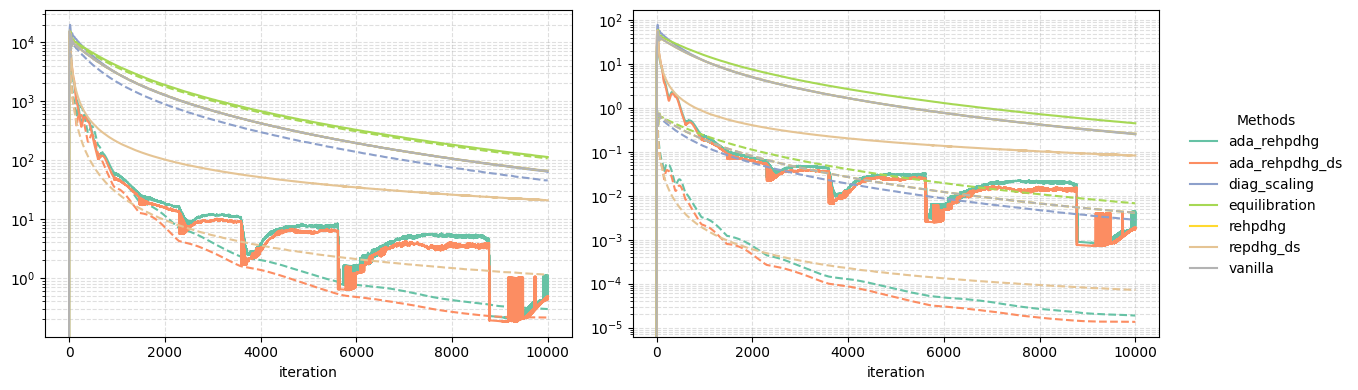

In [16]:
plot_residuals_compare(all_res, dpi=100, dual_scale=True,
                    #    abs_ylim=(1e-7, 1e-3), rel_ylim=(1e-7, 2)
                       )